<a href="https://colab.research.google.com/github/debyyamamoto/atividades_rec_musical/blob/main/lab09_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Descomente e rode para usar no colab
! pip install git+https://github.com/flaviovdf/musica.git

  Cloning https://github.com/flaviovdf/musica.git to /tmp/pip-req-build-dunegzsr
  Running command git clone --filter=blob:none --quiet https://github.com/flaviovdf/musica.git /tmp/pip-req-build-dunegzsr
  Resolved https://github.com/flaviovdf/musica.git to commit 19c84b84ab1cd1a6a6e0fdefbf33fc9c796c1949
  Preparing metadata (setup.py) ... done
  Created wheel for musica_dcc_ufmg: filename=musica_dcc_ufmg-0.1-py3-none-any.whl size=3384 sha256=745767533c572de4ea28a3553708f3c8c863238331d46815493aa4b364263f3d
  Stored in directory: /tmp/pip-ephem-wheel-cache-nwnk17tk/wheels/75/fd/b5/f4508a3d593651a0964d76a8aeb9faf32c1da6dc23cbe5da2a
Successfully built musica_dcc_ufmg


# Shazam do GTZAN

**Objetivos**
1. Entender o Shazam!

**Resultado Esperado**
1. Saber criar um índice de constelações
1. Realizar consultas no mesmo

**Caso queira indexar tudo, recomendo o uso da biblioteca sparse, descomente abaixo**

In [ ]:
from musica import mu_files
from musica import mu_plots

from numba import jit

import librosa
import librosa.display

import IPython.display as ipd

import matplotlib.pyplot as plt

import numpy as np
import os
import pandas as pd

In [ ]:
mu_plots.init_matplotlib()
plt.ion()

In [ ]:
mu_files.download('https://homepages.dcc.ufmg.br/~flaviovdf/mir/lab09/archive.zip',
             'archive.zip', False)
mu_files.download('https://homepages.dcc.ufmg.br/~flaviovdf/mir/lab09/queryPublic_George.zip',
             'queryPublic_George.zip', False)

archive.zip: 1.21GB [02:41, 8.06MB/s]
queryPublic_George.zip: 723MB [01:03, 11.9MB/s]


In [ ]:
mu_files.extract('archive.zip', '.')

In [ ]:
mu_files.extract('queryPublic_George.zip', '.')

In [ ]:
! ls

 archive.zip  'mir-2013-GeorgeDataset_snippet(10sec)_1062'   sample_data
 Data	       queryPublic_George.zip


## Introdução

Neste notebook vamos tentar montar um [Shazam](https://shazam.com). Criado em meados de 2003 \[[1](https://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf)\], o Shazam é um serviço que identifica músicas com base em clipes pequenos. No começo dos anos 2010s, o advento de aplicativos de celulares popularizou o serviço Shazam. Com o passar dos anos, as ideias do Shazam foram copiadas por empresas como a Google a Apple, que incluem variações do serviço de descoberta nos seus sistemas operacionais Android e IOs. Se não me engano, a Apple usa APIs do Shazam, enquanto a Google tem sua versões própria.

![](https://digitalagencynetwork.com/wp-content/uploads/2017/12/confirmed-apple-bought-shazam-app-reasonable-point.jpg)

O funcionamento do Shazam é feito através da técnica de *audio fingerprinting*. Aqui, um índice invertido de atributos musicais é criado. Com tal índice, podemos rapidamente identificar uma música através de um clipe pequeno da mesma. A figura abaixo mostra a ideia de como um serviço seria implementado no mundo real. Aqui, vamos fazer uma versão simples em memória.

![Audio Finger](https://www.audiolabs-erlangen.de/resources/MIR/FMP/data/C7/FMP_C7_F02.png)

## Base de Dados

Para nossa tarefa, vamos fazer uso da base GTZAN. A base GTZAN é composta por 1.000 trechos de música e áudio de meio minuto, classificados individualmente em dez categorias. Por hora, vamos ignorar as categorias e focar apenas nas músicas. Para um melhor entendimento do GTZAN leia a referência \[[2](https://arxiv.org/pdf/1306.1461.pdf)\].

### A base de dados que será indexada (GTZAN)

Toda a base GTZAN pode ser encontrada no [Kaggle](https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification). Caso necessite, uma versão também pode ser encontrada no drive junto deste notebook.

Abaixo mostramos as pastas e arquivos do GTZAN. Tais músicas vem no formato wav. Sua tarefa será montar um índice de um **subconjunto** de tais músicas. Já explico.

In [ ]:
! ls Data/genres_original

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock


In [ ]:
! ls Data/genres_original/blues | head

blues.00000.wav
blues.00001.wav
blues.00002.wav
blues.00003.wav
blues.00004.wav
blues.00005.wav
blues.00006.wav
blues.00007.wav
blues.00008.wav
blues.00009.wav


### A base de dados de consulta (MIREX-2020)

Como sua tarefa é montar um Shazam, precisamos de uma base de consultas. Desde 2005, a [Music Information Retrieval Evaluation eXchange (MIREX 2020)](https://www.music-ir.org/mirex) organiza competições no tema de recuperação de informação musical. Já fazem alguns anos, desde 2013, onde anualmente uma das competições do MIREX é no tema de *audio fingerprinting* (nossa tarefa). O link ao lado contém a descrição da tarefa [Audio Fingerprinting MIREX 2020](https://www.music-ir.org/mirex/wiki/2020:Audio_Fingerprinting).

Para simular o uso do Shazam, junto com tal competição, uma base de dados de consultas é fornecida. Tal base foi gravada em telefones celulares em diferentes ambientes. Para entender o formato de tal base, segue uma lista dos arquivos.

In [ ]:
! ls -l mir-2013-GeorgeDataset_snippet\(10sec\)_1062

total 921780
-rw-r--r-- 1 root root 884782 Dec 20 18:25 blues.00000-snippet-10-0.wav
-rw-r--r-- 1 root root 884782 Dec 20 18:25 blues.00000-snippet-10-10.wav
-rw-r--r-- 1 root root 884782 Dec 20 18:25 blues.00000-snippet-10-20.wav
-rw-r--r-- 1 root root 884782 Dec 20 18:25 blues.00003-snippet-10-0.wav
-rw-r--r-- 1 root root 884782 Dec 20 18:25 blues.00003-snippet-10-10.wav
-rw-r--r-- 1 root root 884782 Dec 20 18:25 blues.00003-snippet-10-20.wav
-rw-r--r-- 1 root root 884782 Dec 20 18:25 blues.00004-snippet-10-0.wav
-rw-r--r-- 1 root root 884782 Dec 20 18:25 blues.00004-snippet-10-10.wav
-rw-r--r-- 1 root root 884782 Dec 20 18:25 blues.00005-snippet-10-0.wav
-rw-r--r-- 1 root root 884782 Dec 20 18:25 blues.00005-snippet-10-10.wav
-rw-r--r-- 1 root root 884782 Dec 20 18:25 blues.00005-snippet-10-20.wav
-rw-r--r-- 1 root root 884782 Dec 20 18:25 blues.00009-snippet-10-0.wav
-rw-r--r-- 1 root root 884782 Dec 20 18:25 blues.00009-snippet-10-10.wav
-rw-r--r-- 1 root root 884782 Dec 20 18:25 

In [ ]:
!apt-get install libportaudio2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 65.3 kB of archives.
After this operation, 223 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Fetched 65.3 kB in 0s (431 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 123634 files and directories currently installed.)
Preparing to unpack .../libportaudio2_19.6.0-1.1_amd64.deb ...
Unpacking libportaudio2:amd64 (19.6.0-1.1) ...
Setting up libportaudio2:amd64 (19.6.0-1.1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.4) ...
/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_loader.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbi

Observe como cada arquivo corresponde a uma música do GTZAN. Além do mais, três clipes de 10 segundos são fornecidos por música. Por exemplos, a música `blues.00000.wav`do GTZAN tem como respostas os clipes: `blues.00000-snippet-10-0.wav`, `blues.00000-snippet-10-10.wav`, `blues.00000-snippet-10-20.wav`.

## Sua Tarefa

Sabendo das bases acima, sua tarefa será em indexar e mensurar a Precision@10 (fração de acertos na primeira posição retornada) das músicas acima. **Por questões de memória limitada, você pode indexar apenas as músicas de consulta, não precisa indexar todo GTZAN. Faça tudo na memória principal mesmo**.

Para realizar sua tarefa crie mapas de constetalação das músicas e da consulta.

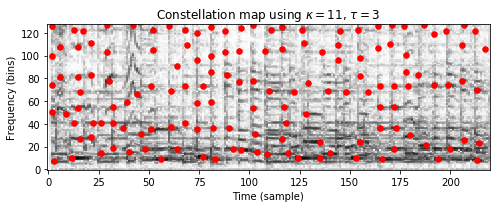

### *Importante*: Fourier no GTZAN

No GTZAN, cada música é gravada a uma taxa de amostragem de 22,05 kHz e arquivos de áudio mono de 16 bits no formato `.wav`. *Como toda música tem a mesma taxa de amostragem, os índices discretos da transformada de Fourier são os mesmos para todas as músicas. ELAS JÁ VEM BINARIZADAS NO EIXO-Y do mapa de constelação*.

## Carregando os Espectrogramas

O código abaixo carrega os espectrogramas. Coloquei também um função que plota os mesmos.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def plot_spec(stft, sr, constelation=None):
    fig, ax = plt.subplots()
    img = librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max),
                                   y_axis='log',
                                   x_axis='time',
                                   hop_length=sr,
                                   ax=ax)
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    if constelation is not None and constelation.any():
        x, y = np.where(constelation.T)
        ax.scatter(x, y, s=100, alpha=0.6, edgecolor='k')
    fig.show()

**Observe como passo o `hop_length=sr` no stft**. Como estou com uma música com taxa SR por segundo, tiro a média a cada SR frames. Isso deixa meu espectrograma em SEGUNDOS. Algumas musicas passam um pouco de 30 segundos, portanto pego os trinta na marra.

In [ ]:
def my_stft(wave, sr):
    stft_complex = librosa.stft(wave, hop_length=sr) # deve ter approx 30 secs
    stft = np.abs(stft_complex) # tira a norma do real e imag
    return stft[:, :30] # força 30 secs

(1025, 30)

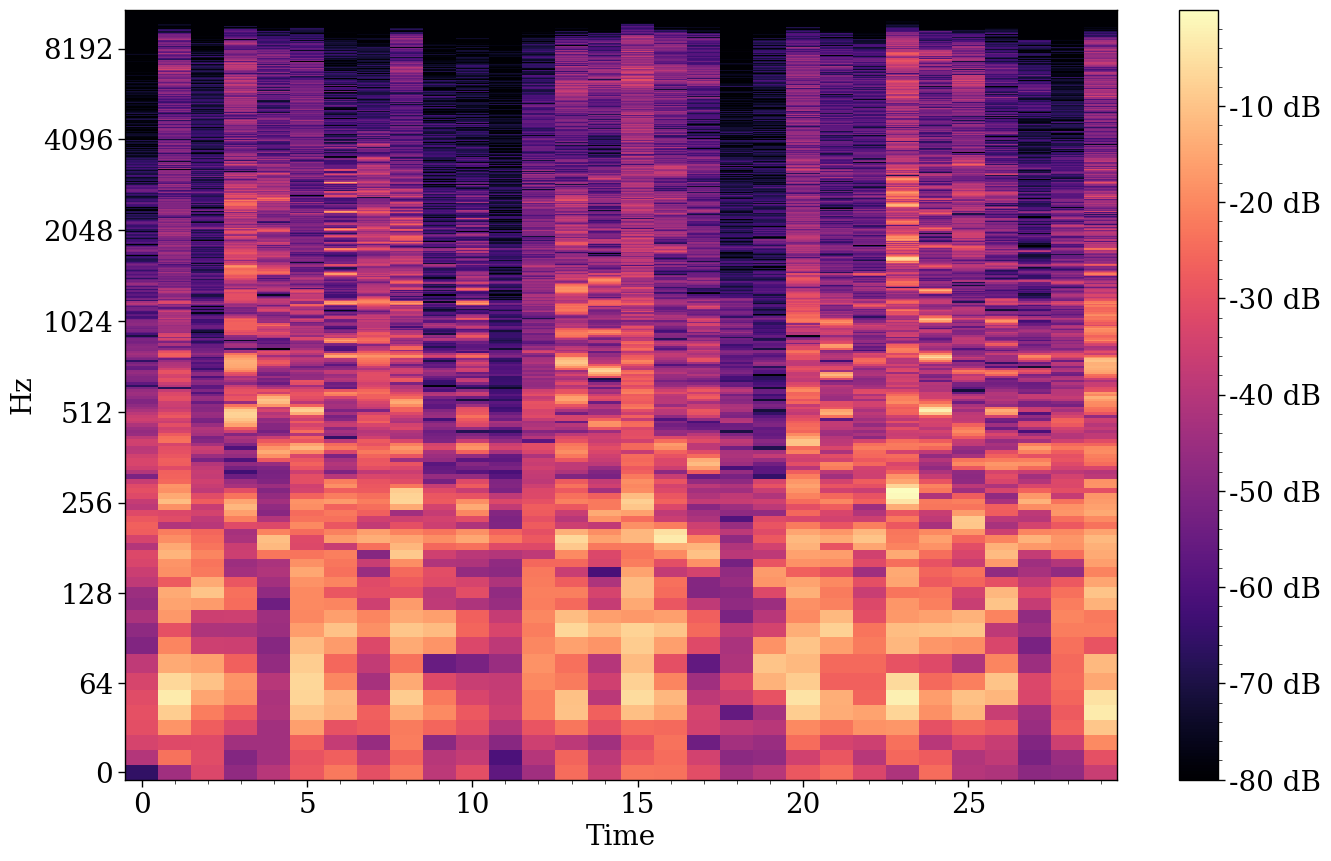

In [ ]:
wave, sr = librosa.load('Data/genres_original/blues/blues.00001.wav',
                        mono=True)
stft = my_stft(wave, sr)
plot_spec(stft, sr)
stft.shape

### Mapa de Constelação

O mapa pode ser implementado com a chamada: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.maximum_filter.html. O `mode='constant'` faz um preenchimento nas bordas para garantir que tudo funcione. O `size` diz o tamanho do filtro que vamos usar.

In [ ]:
from scipy import ndimage
kappa = 5
tau = 5
def constellation_map(stft, kappa, tau, thresh=0.01):
    result = ndimage.maximum_filter(stft, size=[2*kappa+1, 2*tau+1],
                                    mode='constant')
    C = np.logical_and(stft == result, result > thresh)
    return C

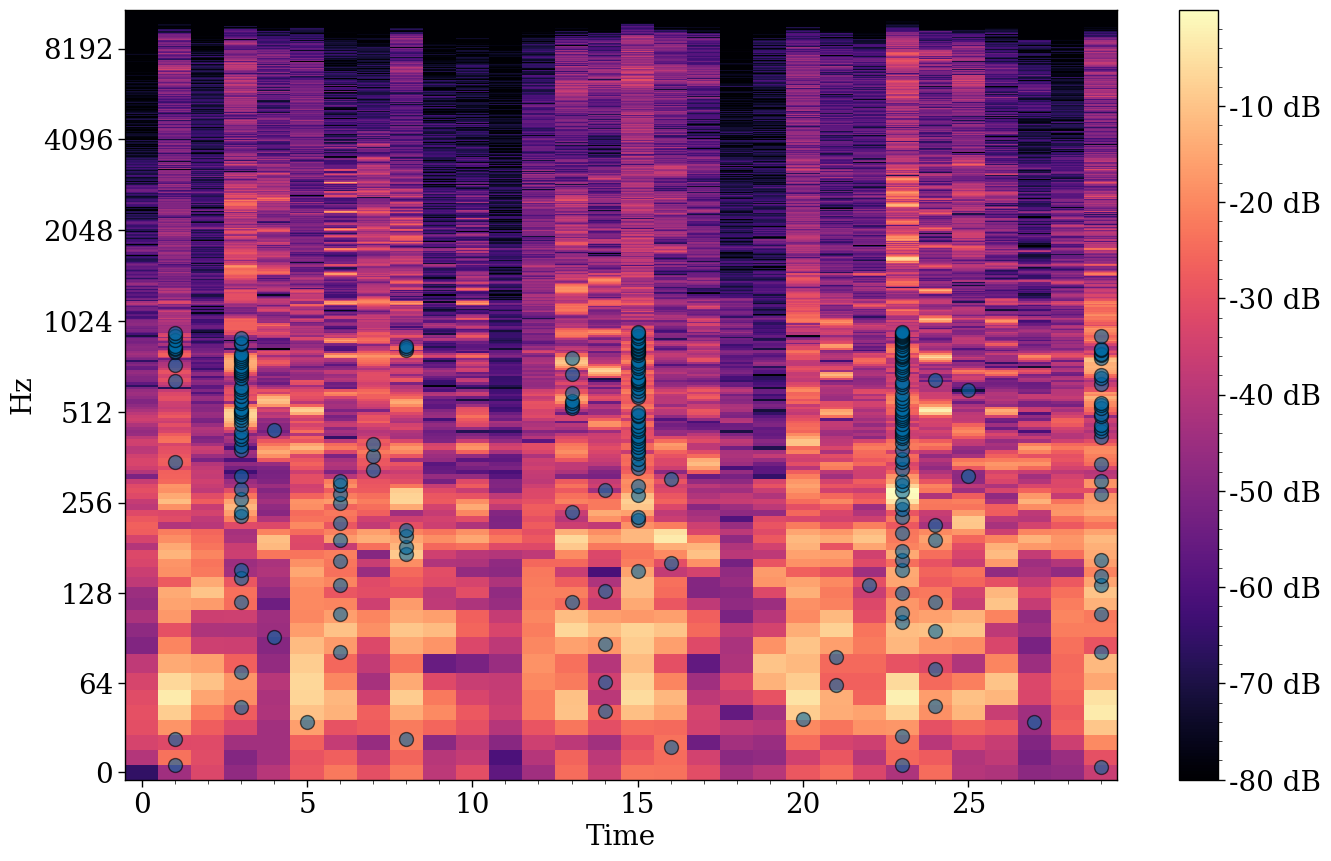

In [ ]:
constelation = constellation_map(stft, kappa=kappa, tau=tau)
plot_spec(stft, sr, constelation)

## Índice

Observe como cada consulta precisa ser comparada com todas as seções (tendo a mesma duração da consulta) de todas as músicas contidas no base de dados. Tal estratégia de busca exaustiva, cujo tempo de execução depende linearmente do número e do tamanho da base de dados, não é viável. Portanto você deve implementar um índice como visto em sala de aula. A função `match_query_gtzan` lhe ajuda a carregar apenas os arquivos que existem na base de consultas.

In [ ]:
import glob
import os

def match_query_gtzan():
    rv = {}
    path = os.path.join('mir-2013-GeorgeDataset_snippet(10sec)_1062', '*.wav')
    for wav_fpath in glob.glob(path):
        file_name = os.path.basename(wav_fpath)
        file_name_gztan = '{}{}'.format(file_name.split('-')[0], '.wav')
        genre = file_name_gztan.split('.')[0]
        rv[wav_fpath] = os.path.join('Data', 'genres_original', genre,
                                     file_name_gztan)
    return rv
matches = match_query_gtzan()
print(list(matches.items())[:10])

[('mir-2013-GeorgeDataset_snippet(10sec)_1062/jazz.00035-snippet-10-0.wav', 'Data/genres_original/jazz/jazz.00035.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/jazz.00013-snippet-10-20.wav', 'Data/genres_original/jazz/jazz.00013.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/rock.00034-snippet-10-20.wav', 'Data/genres_original/rock/rock.00034.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/disco.00012-snippet-10-10.wav', 'Data/genres_original/disco/disco.00012.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/rock.00024-snippet-10-0.wav', 'Data/genres_original/rock/rock.00024.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/jazz.00014-snippet-10-20.wav', 'Data/genres_original/jazz/jazz.00014.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/disco.00065-snippet-10-10.wav', 'Data/genres_original/disco/disco.00065.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/classical.00050-snippet-10-10.wav', 'Data/genres_original/classical/classical.00050.wav'), ('mir-2013-G

## Problemas

1. Implemente o índice acima. É possível implementar o mesmo na memória. Use estruturas python ou uma matriz esparsa 3d (um tensor). Veja a descrição do lab. Da para fazer sem o sparse, mas não deve funcionar na base toda.
1. Realize as consultas e mensure o seu valor de precision@10
1. Qual o efeito do kappa e do tau no seu resultado?
1. Mude seu código para funciona na base toda (*extra*)

1. Ok, até aqui, foi criado o espectograma, o mapa de constelações, agora não queremos utilizar uma solução bruta de navegar pelas janelas do mapa, vamos criar um índice invertido do mapa

Se sabemos o tempo e a frequência, listamos os áudios que estão presentes nessas coordenadas.

O índice criado será um dicionário onde:
- A chave é uma coordenada (row, col) da constelação.
- O valor é uma lista de índices de arquivos (file_idx) que possuem pontos na mesma coordenada.

In [ ]:
# ! ls Data/genres_original/metal

In [ ]:
# wave, sr = librosa.load("mir-2013-GeorgeDataset_snippet(10sec)_1062/metal.00015-snippet-10-0.wav", mono=True)
# stft = my_stft(wave, sr)
# constellation = constellation_map(stft, kappa, tau)
# plot_spec(stft, sr, constellation)

In [ ]:
# wave, sr = librosa.load("Data/genres_original/metal/metal.00015.wav", mono=True)
# stft = my_stft(wave, sr)
# constellation = constellation_map(stft, kappa, tau)
# plot_spec(stft, sr, constellation)

Ao tentar baixar os arquivos GTZAN, alguns arquivos constaram vazios, então eu adicionei uma exceção para que eles fossem pulados na análise

In [ ]:
from collections import defaultdict
from scipy.sparse import coo_matrix

def index(colecao_de_stfts, kappa, tau):
    idx = defaultdict(list)
    file_list = list(colecao_de_stfts)

    for file_idx, file_path in enumerate(file_list):
      try:
        wave, sr = librosa.load(file_path, mono=True)
      except Exception as e:
        continue

      stft = my_stft(wave, sr)
      constellation = constellation_map(stft, kappa, tau)

      row, col = np.where(constellation) #identifica as coordenadas no mapa de constelação onde existem valores verdadeiros
      for r, c in zip(row, col):
        idx[(r, c)].append((file_idx, c))

    return idx, file_list


2. Agora vamos realizar as consultas e fazer sua verificar o valor de precisão -> para isso, vamos pegar os arquivos disponibilizados pelo LAMIR e comparar com os índices que acabamos de gerar

- Uma coisa importante: A função match_query_gtzan() é responsável por criar um mapeamento entre os arquivos de consulta do GeorgeDataset (trechos de 10 segundos usados como consultas) e os arquivos correspondentes na base GTZAN, que contém as músicas completas organizadas por gênero.


A função match_query_gtzan() realiza o seguinte:

- Itera sobre os arquivos do GeorgeDataset:
    Usa glob para localizar todos os arquivos de consulta (e.g., blues-00001-clip.wav).

- Extrai informações do nome do arquivo:
    Separa o gênero (blues) e o identificador da música (00001) a partir do nome do arquivo no GeorgeDataset.

- Constrói o caminho para o arquivo correspondente na GTZAN:
    Com base no gênero e no identificador, monta o caminho do arquivo completo na base GTZAN (e.g., genres_original/blues/blues.00001.wav).

In [ ]:
from collections import Counter
def query(query_file, index, kappa, tau, thresh=0.01):
  wave, sr = librosa.load(query_file, mono=True)
  stft = my_stft(wave, sr)
  constellation = constellation_map(stft, kappa, tau)

  matches = []
  for n, h in zip(*np.where(constellation)):
    if (n,h) in index:
      for file_id, time_index in index[(n,h)]:
        time_difference = time_index - n
        matches.append((file_id, time_difference))

  file_counts = Counter([file_id for file_id, _ in matches])

  unique_results = []
  seen_files = set()

  for filee, count in file_counts.most_common(20):
    if filee not in seen_files:
        unique_results.append((filee, count))
        seen_files.add(filee)


  return unique_results

In [ ]:
k = 5
t = 5
colecao_indexada, file_list = index(matches.values(), kappa=k, tau=t)

In [ ]:
res = query("mir-2013-GeorgeDataset_snippet(10sec)_1062/metal.00015-snippet-10-10.wav", colecao_indexada, kappa=k, tau=t)
for file_idx, count in res:
  print(f"  Arquivo: {file_list[file_idx]} - Pontos Correspondentes: {count}")

  Arquivo: Data/genres_original/metal/metal.00020.wav - Pontos Correspondentes: 5
  Arquivo: Data/genres_original/metal/metal.00020.wav - Pontos Correspondentes: 5
  Arquivo: Data/genres_original/metal/metal.00020.wav - Pontos Correspondentes: 5
  Arquivo: Data/genres_original/jazz/jazz.00009.wav - Pontos Correspondentes: 4
  Arquivo: Data/genres_original/jazz/jazz.00009.wav - Pontos Correspondentes: 4
  Arquivo: Data/genres_original/pop/pop.00074.wav - Pontos Correspondentes: 4
  Arquivo: Data/genres_original/pop/pop.00074.wav - Pontos Correspondentes: 4
  Arquivo: Data/genres_original/pop/pop.00074.wav - Pontos Correspondentes: 4
  Arquivo: Data/genres_original/hiphop/hiphop.00010.wav - Pontos Correspondentes: 4
  Arquivo: Data/genres_original/hiphop/hiphop.00010.wav - Pontos Correspondentes: 4
  Arquivo: Data/genres_original/hiphop/hiphop.00010.wav - Pontos Correspondentes: 4
  Arquivo: Data/genres_original/hiphop/hiphop.00040.wav - Pontos Correspondentes: 3
  Arquivo: Data/genres_o

In [ ]:
results = {}
for query_file in matches.keys():
  results[query_file] = query(query_file, colecao_indexada, kappa=5, tau=5)

In [ ]:
for query, res in results.items():
    print(f"Consulta: {query}")
    for file_idx, count in res:
        print(f"  Arquivo: {file_list[file_idx]} - Pontos Correspondentes: {count}")

A saída de streaming foi truncada nas últimas 5000 linhas.
  Arquivo: Data/genres_original/metal/metal.00045.wav - Pontos Correspondentes: 5
  Arquivo: Data/genres_original/metal/metal.00045.wav - Pontos Correspondentes: 5
Consulta: mir-2013-GeorgeDataset_snippet(10sec)_1062/jazz.00044-snippet-10-0.wav
  Arquivo: Data/genres_original/rock/rock.00014.wav - Pontos Correspondentes: 7
  Arquivo: Data/genres_original/rock/rock.00014.wav - Pontos Correspondentes: 7
  Arquivo: Data/genres_original/rock/rock.00014.wav - Pontos Correspondentes: 7
  Arquivo: Data/genres_original/reggae/reggae.00039.wav - Pontos Correspondentes: 5
  Arquivo: Data/genres_original/reggae/reggae.00039.wav - Pontos Correspondentes: 5
  Arquivo: Data/genres_original/reggae/reggae.00039.wav - Pontos Correspondentes: 5
  Arquivo: Data/genres_original/disco/disco.00003.wav - Pontos Correspondentes: 5
  Arquivo: Data/genres_original/disco/disco.00003.wav - Pontos Correspondentes: 5
  Arquivo: Data/genres_original/disco/di

Ok, agora podemos ir para a parte de cálculo da precisão

**Definição de Precisão:** Precisão indica o número total de previsões especificadas como positivas que são atribuídas corretamente.

Cada arquivo de áudio tem um square, que é o quão similar ele é da query, eles foram rankeados acima, podemos definir um corte K, para cada K, temos uma precisão e uma revocação.

Para definir a relação de cada música vamos definir que um retorno de uma música do mesmo gênero é positivo e de qualquer outro é negativo.

O parâmetro kappa é normalmente usado para definir o limiar de magnitude dos pontos no espectograma para serem incluídos no mapa de constelação. Determina quais valores no espectograma são considerados pontos relevantes. Um valor mais alto para kappa fará com que apenas pontos com magnitude mais alta sejam incluídos, enquanto quando o valor de kappa é mantido baixo, ele inclui mais pontos, porém pode acabar captando ruídos.

Um kappa maior tende a resultar em mapas de constelação mais esparso.

In [ ]:
k = 5
t = 5
colecao_indexada, file_list = index(matches.values(), kappa=k, tau=t)

In [ ]:
res = query("mir-2013-GeorgeDataset_snippet(10sec)_1062/metal.00015-snippet-10-10.wav", colecao_indexada, kappa=k, tau=t)
for file_idx, count in res:
  print(f"  Arquivo: {file_list[file_idx]} - Pontos Correspondentes: {count}")

  Arquivo: Data/genres_original/metal/metal.00020.wav - Pontos Correspondentes: 5
  Arquivo: Data/genres_original/metal/metal.00020.wav - Pontos Correspondentes: 5
  Arquivo: Data/genres_original/metal/metal.00020.wav - Pontos Correspondentes: 5
  Arquivo: Data/genres_original/jazz/jazz.00009.wav - Pontos Correspondentes: 4
  Arquivo: Data/genres_original/jazz/jazz.00009.wav - Pontos Correspondentes: 4
  Arquivo: Data/genres_original/pop/pop.00074.wav - Pontos Correspondentes: 4
  Arquivo: Data/genres_original/pop/pop.00074.wav - Pontos Correspondentes: 4
  Arquivo: Data/genres_original/pop/pop.00074.wav - Pontos Correspondentes: 4
  Arquivo: Data/genres_original/hiphop/hiphop.00010.wav - Pontos Correspondentes: 4
  Arquivo: Data/genres_original/hiphop/hiphop.00010.wav - Pontos Correspondentes: 4
  Arquivo: Data/genres_original/hiphop/hiphop.00010.wav - Pontos Correspondentes: 4
  Arquivo: Data/genres_original/hiphop/hiphop.00040.wav - Pontos Correspondentes: 3
  Arquivo: Data/genres_o

In [ ]:
k = 8
t = 8
colecao_indexada, file_list = index(matches.values(), kappa=k, tau=t)

In [ ]:
res = query("mir-2013-GeorgeDataset_snippet(10sec)_1062/metal.00015-snippet-10-10.wav", colecao_indexada, kappa=k, tau=t)
for file_idx, count in res:
  print(f"  Arquivo: {file_list[file_idx]} - Pontos Correspondentes: {count}")

  Arquivo: Data/genres_original/jazz/jazz.00014.wav - Pontos Correspondentes: 2
  Arquivo: Data/genres_original/jazz/jazz.00014.wav - Pontos Correspondentes: 2
  Arquivo: Data/genres_original/jazz/jazz.00014.wav - Pontos Correspondentes: 2
  Arquivo: Data/genres_original/rock/rock.00040.wav - Pontos Correspondentes: 2
  Arquivo: Data/genres_original/rock/rock.00040.wav - Pontos Correspondentes: 2
  Arquivo: Data/genres_original/reggae/reggae.00045.wav - Pontos Correspondentes: 2
  Arquivo: Data/genres_original/reggae/reggae.00045.wav - Pontos Correspondentes: 2
  Arquivo: Data/genres_original/reggae/reggae.00045.wav - Pontos Correspondentes: 2
  Arquivo: Data/genres_original/hiphop/hiphop.00080.wav - Pontos Correspondentes: 2
  Arquivo: Data/genres_original/hiphop/hiphop.00080.wav - Pontos Correspondentes: 2
  Arquivo: Data/genres_original/hiphop/hiphop.00080.wav - Pontos Correspondentes: 2
  Arquivo: Data/genres_original/rock/rock.00034.wav - Pontos Correspondentes: 1
  Arquivo: Data/

O parâmetro tau é usado para limiar o alcance temporal entre pares de pontos no mapa de constelação. Define o intervalo no tempo no qual as correspondências ou conexões entre pontos no mapa de constelações são considerados.